In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
from tensorflow.keras import metrics,optimizers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [2]:
#Setting up images path
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/7classes_data/"
SELECTED_CLASS = "10000_NoF_Class.csv"
SELECTED_LABEL = "Is No_Finding"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob('temp/*/*/*.jpg')))
image_csv = pd.read_csv(PATH+SELECTED_CLASS)
CLASS_NAME = image_csv[SELECTED_LABEL].unique()
# Check number of TRUE file and all file count        
print(image_num)
print(CLASS_NAME)

10000
['No' 'Yes']


In [3]:
##loading image from given path
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + "temp/train/"
VALID_PATH = PATH + "temp/valid/"
TEST_PATH = PATH + "temp/test/"
#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
#This will be my valid_set . 
data_gen_valid = my_generator.flow_from_directory(directory=VALID_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
x_train,y_train = next(data_gen_train)
x_valid,y_valid = next(data_gen_valid)
x_test,y_test = next(data_gen_test)

Found 8001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
##using pre-trained IncpetionV3 Model
#myInception = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights=None,
#                                                 input_shape=(224,224,3),)
#out = myInception.output
#out = layers.Flatten()(out)
#out = layers.Dropout(0.3)(out)
#out = layers.Dense(1024,activation='relu')(out)
#out = layers.Dense(1,activation='sigmoid')(out)
#
#myModel = Model(myInception.input,out)
##Using pre-trained tensorflow hub InceptionV3
myInception = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/4",
                            trainable = False)
myModel = tf.keras.Sequential([
    myInception,
    layers.Dropout(0.4),
    layers.Dense(1024,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])
myModel.build([None,224,224,3])

In [5]:
myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  23853833  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1026048   
_________________________________________________________________
dense_1 (Dense)              multiple                  1025      
Total params: 24,880,906
Trainable params: 1,027,073
Non-trainable params: 23,853,833
_________________________________________________________________


In [6]:
## Setting up callback function for detecting training status
myEarly = EarlyStopping(monitor='val_loss',patience=10,verbose=1)
myCheckpoint = ModelCheckpoint('myInceptionV3.hdf5',monitor='val_loss')
#Callback function when my model hit my max ACC
class mystopclass(Callback):
    def on_epoch_end(self,epoch,log={}):
        if(log.get('accuracy') > 0.999 or log.get('loss') < 0.001):
            print("\n\nReached my Destination. Stoppped Training!!\n\n")
            self.model.stop_training = True
myStop = mystopclass()

In [7]:
myModel.compile(loss='binary_crossentropy',
                    optimizer=optimizers.SGD(lr=1e-4)
                ,metrics=['accuracy',metrics.AUC(),metrics.Precision(),
               metrics.Recall()])

In [8]:
TRAIN_IMG = 8001
TEST_IMG = 1000
VALID_IMG = 1000

In [9]:
#Training myModel
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
mySession = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 100,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = 30,
                               verbose = 1,
                               callbacks=[myCheckpoint,myStop])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 251.0 steps, validate for 30 steps
Epoch 1/100
251/251 [==============================] - 32s 129ms/step - loss: 0.6118 - accuracy: 0.7683 - auc: 0.5092 - precision: 0.1537 - recall: 0.1072 - val_loss: 0.4908 - val_accuracy: 0.8052 - val_auc: 0.5542 - val_precision: 0.1818 - val_recall: 0.0828
Epoch 2/100
251/251 [==============================] - 22s 86ms/step - loss: 0.5757 - accuracy: 0.7947 - auc: 0.5177 - precision: 0.1606 - recall: 0.0744 - val_loss: 0.4746 - val_accuracy: 0.8208 - val_auc: 0.5681 - val_precision: 0.2000 - val_recall: 0.0621
Epoch 3/100
251/251 [==============================] - 22s 88ms/step - loss: 0.5580 - accuracy: 0.7993 - auc: 0.5303 - precision: 0.1667 - recall: 0.0712 - val_loss: 0.4613 - val_accuracy: 0.8198 - val_auc: 0.5840 - val_precision: 0.1500 - val_recall: 0.0414
Epoch 4/100
251/251 [==============================] - 22s 88ms/step - loss: 0.5421 - accuracy: 0.8039 - auc: 0.5417 - precision: 0.2019 - recall: 0.0864 - val_loss: 0.4509 - va

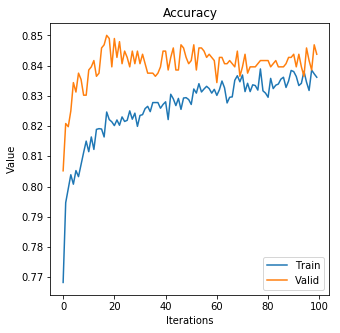

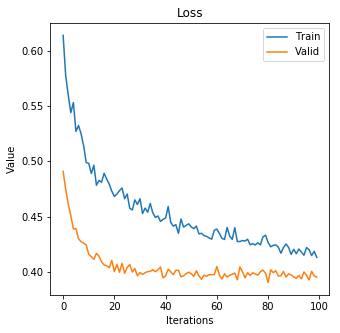

In [10]:
plt.figure(figsize=(5,5))
plt.plot(mySession.history['accuracy'])
plt.plot(mySession.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig("Phase1_InceptionV3_Accuracy.png")
plt.show()
plt.figure(figsize=(5,5))
plt.plot(mySession.history['loss'])
plt.plot(mySession.history['val_loss'])
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig("Phase1_InceptionV3_Loss.png")
plt.show()

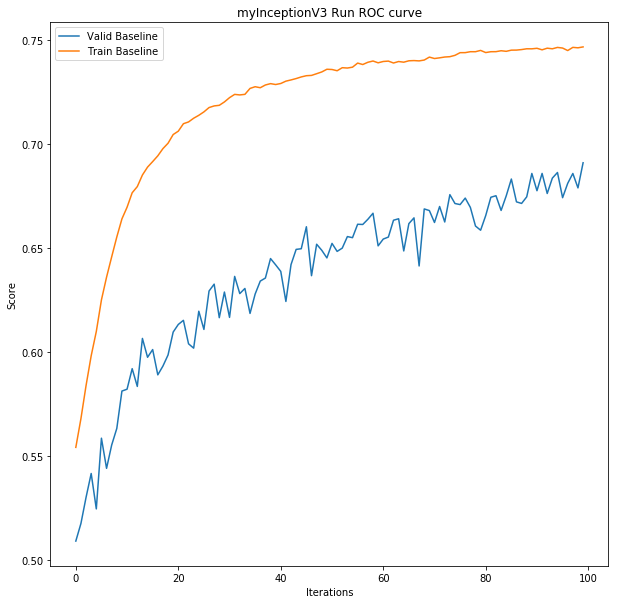

In [11]:
plt.figure(figsize=(10,10))
plt.plot(mySession.history['auc'])
plt.plot(mySession.history['val_auc'])
plt.title("myInceptionV3 Run ROC curve")
plt.legend({'Train Baseline','Valid Baseline'})
plt.ylabel('Score')
plt.xlabel('Iterations')
plt.savefig("myIncp3_Run_ROC.png")
plt.show()

In [12]:
import pandas as pd
siss_history = pd.DataFrame(mySession.history)

In [14]:
siss_history.to_csv('IncepV3_NoF_History.csv')